In [135]:
import os
import pickle
import json
from tqdm.auto import tqdm
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sesm import get_data
from trainer import PLModel

In [204]:
SPLIT_ID = 9

SPLITS = [
{"validation_ids": [43,13,4,35,11], "test_ids": [14,3,25,52,30]},
{"validation_ids": [51,30,5,49,12], "test_ids": [18,2,11,42,39]},
{"validation_ids": [4,9,13,40,7], "test_ids": [52,29,22,35,17]},
{"validation_ids": [47,51,35,37,39], "test_ids": [2,23,28,42,41]},
{"validation_ids": [44,16,5,7,15], "test_ids": [51,30,40,52,20]},
{"validation_ids": [51,42,6,12,5], "test_ids": [31,46,36,2,39]},
{"validation_ids": [24,32,1,9,19], "test_ids": [39,5,27,25,15]},
{"validation_ids": [49,34,19,28,44], "test_ids": [13,29,41,16,50]},
{"validation_ids": [28,34,26,1,29], "test_ids": [35,11,51,21,6]},
{"validation_ids": [11,3,28,41,39], "test_ids": [25,42,6,1,51]},
]

CLASS_DICT = {
    0: "Left",
    1: "Right"
}

def get_freer_gpu():
    # Run nvidia-smi command to get GPU memory info
    command = "nvidia-smi --query-gpu=memory.free,memory.total --format=csv,noheader,nounits"
    output = os.popen(command).read().strip().split('\n')

    # Parse the output to find GPU with most free memory
    max_memory = -1
    max_memory_index = -1
    for index, line in enumerate(output):
        free_memory, _ = map(int, line.split(', '))
        if free_memory > max_memory:
            max_memory = free_memory
            max_memory_index = index

    return max_memory_index

free_gpu_id = get_freer_gpu()
#free_gpu_id=0
print("select gpu:", free_gpu_id)
torch.cuda.set_device(torch.device(free_gpu_id))

select gpu: 2


In [205]:
config = json.load(open(f"configs/motor_imagery.json", "r"))
#config = json.load(open(f"configs/sleep_edf_exp17-19.json", "r"))
train_loader, val_loader, test_loader, class_weights, max_len = get_data(
    config["dataset"], "E:\s222165064", config["batch_size"],
    SPLITS[SPLIT_ID]["validation_ids"],
    SPLITS[SPLIT_ID]["test_ids"]
)
config.update({"class_weights": class_weights, "max_len": max_len})

Load training set:
Loading E:\s222165064\motor_imagery\prepared\s02.npz ...
Loading E:\s222165064\motor_imagery\prepared\s04.npz ...
Loading E:\s222165064\motor_imagery\prepared\s05.npz ...
Loading E:\s222165064\motor_imagery\prepared\s07.npz ...
Loading E:\s222165064\motor_imagery\prepared\s08.npz ...
Loading E:\s222165064\motor_imagery\prepared\s09.npz ...
Loading E:\s222165064\motor_imagery\prepared\s10.npz ...
Loading E:\s222165064\motor_imagery\prepared\s12.npz ...
Loading E:\s222165064\motor_imagery\prepared\s13.npz ...
Loading E:\s222165064\motor_imagery\prepared\s14.npz ...
Loading E:\s222165064\motor_imagery\prepared\s15.npz ...
Loading E:\s222165064\motor_imagery\prepared\s16.npz ...
Loading E:\s222165064\motor_imagery\prepared\s17.npz ...
Loading E:\s222165064\motor_imagery\prepared\s18.npz ...
Loading E:\s222165064\motor_imagery\prepared\s19.npz ...
Loading E:\s222165064\motor_imagery\prepared\s20.npz ...
Loading E:\s222165064\motor_imagery\prepared\s21.npz ...
Loading E:\s

In [206]:
plmodel = PLModel(stage=2, **config)
plmodel.model.load_state_dict(torch.load(f"models/trained_model_split{SPLIT_ID}.pt"))

model = plmodel.model
model.eval()
model.training

False

# Calculate Accuracy

In [139]:
y_true = []
y_pred = []

for x, y in tqdm(test_loader):
    y_hat, _, _, _ = model(x)
    y_true.append(y.detach().cpu().numpy())
    y_pred.append(((y_hat > 0.5)+0).ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

  0%|          | 0/16 [00:00<?, ?it/s]

In [129]:
output_location = 'test_outputs/motor_imagery'

os.makedirs(output_location, exist_ok=True)
os.makedirs(f"{output_location}/split{SPLIT_ID}", exist_ok=True)

with open(f'{output_location}/split{SPLIT_ID}/y_true_test.pkl','wb') as f:
    pickle.dump(y_true, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{output_location}/split{SPLIT_ID}/y_pred_test.pkl','wb') as f:
    pickle.dump(y_pred, f, protocol=pickle.HIGHEST_PROTOCOL)

Accuracy: 0.546
Precision: 0.6121469808082385
Recall: 0.546


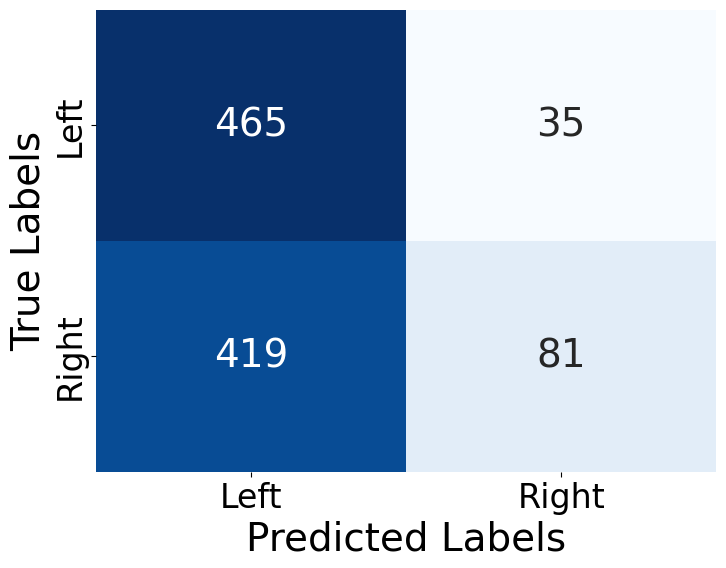

Classification Report:
              precision    recall  f1-score   support

        Left       0.53      0.93      0.67       500
       Right       0.70      0.16      0.26       500

    accuracy                           0.55      1000
   macro avg       0.61      0.55      0.47      1000
weighted avg       0.61      0.55      0.47      1000



Accuracy for Left: 93.00%
Accuracy for Right: 16.20%


In [142]:
class_names = CLASS_DICT.values()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize":28})
plt.xlabel('Predicted Labels', fontsize=28)
plt.gca().set_xticklabels(class_names, fontsize=24)
plt.ylabel('True Labels', fontsize=28)
plt.gca().set_yticklabels(class_names, fontsize=24)
plt.show()
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)
# Calculate class-wise accuracy
class_accuracy = confusion.diagonal()/confusion.sum(axis=1)
print("\n")
# Print class-wise accuracy
for i, class_name in enumerate(class_names):
    print(f'Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%')

# Calculate APOC

In [207]:
AOPC = torch.zeros(config['n_heads'])
total = 0

for x,y in tqdm(test_loader):
    y_hat_, _, selective_actions, relevance_weights = model(x,ignore_relevance_weights=True) 
    batch_size = x.shape[0]
    
    relevance_weights = relevance_weights.detach().cpu()
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    
    attn_arg = torch.sort(relevance_weights, 1, descending=True)[1] 
    
    attn_logits = y_hat_ * relevance_weights.unsqueeze(-1)
    
    for i in range(config['n_heads']):
        AOPC[i] += torch.sigmoid(attn_logits[:, i:].sum(1))[torch.arange(batch_size).long()].sum()
        
    total += batch_size

    del x
    del y
    del y_hat_
    del relevance_weights
    del attn_arg
    del attn_logits
    # break

  0%|          | 0/16 [00:00<?, ?it/s]

In [208]:
output_location = 'test_outputs/motor_imagery'

os.makedirs(output_location, exist_ok=True)
os.makedirs(f"{output_location}/split{SPLIT_ID}/", exist_ok=True)

with open(f'{output_location}/split{SPLIT_ID}/AOPC.pkl','wb') as f:
    pickle.dump(AOPC, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{output_location}/split{SPLIT_ID}/total.pkl','wb') as f:
    pickle.dump(total, f, protocol=pickle.HIGHEST_PROTOCOL)

# Create Plots

## Kernel Size

In [62]:
experiment_ids = [33, 34, 35, 22, 36,41]
kernel_size = [10,20,30,40,50,60]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


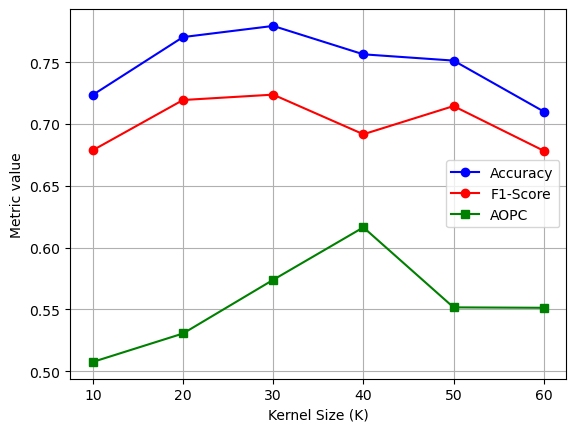

In [63]:
# Plotting
plt.plot(kernel_size, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(kernel_size, f1_scores, marker='o', color='red', label='F1-Score')
plt.plot(kernel_size, aopc_scores, marker='s', color='green', label='AOPC')

# Axis labels
plt.xlabel('Kernel Size (K)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(kernel_size)

plt.grid(True)

# Legend
plt.legend()

# Show plot
plt.show()

## Number of Heads

In [74]:
experiment_ids = [21, 22, 23, "16-2", 25, 29]
n_heads = [4,5,6,7,8,9]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


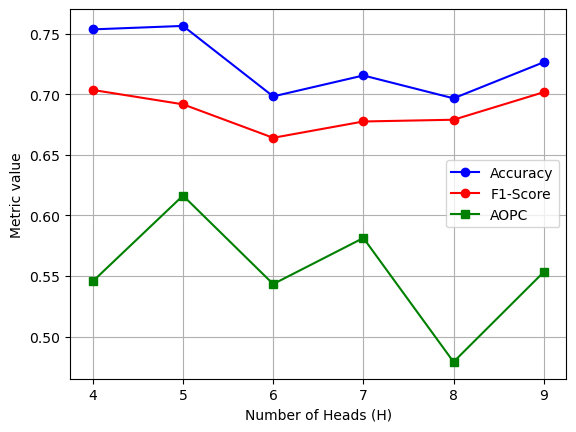

In [75]:
# Plotting
plt.plot(n_heads, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(n_heads, f1_scores, marker='o', color='red', label='F1-Score')
plt.plot(n_heads, aopc_scores, marker='s', color='green', label='AOPC')

# Axis labels
plt.xlabel('Number of Heads (H)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(n_heads)

plt.grid(True)

# Legend
plt.legend(loc='right')

# Show plot
plt.show()

In [18]:
print(accuracies)
print(aopc_scores)

[0.7423954372623575, 0.7619346733668342, 0.7971105527638191, 0.7568124207858048]
[tensor(0.6052), tensor(0.5359), tensor(0.4394), tensor(0.7686)]


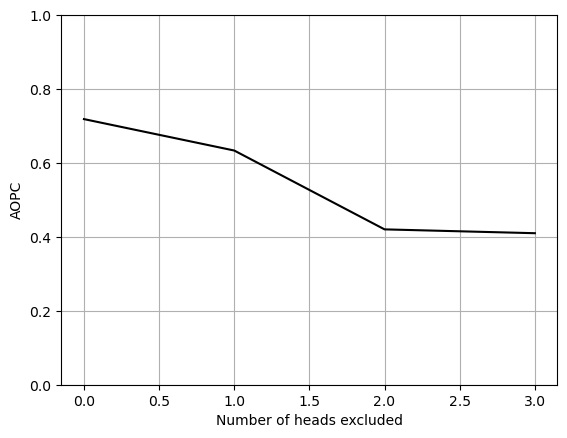

In [68]:
with open(f'test_outputs/exp21/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp21/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(4), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()


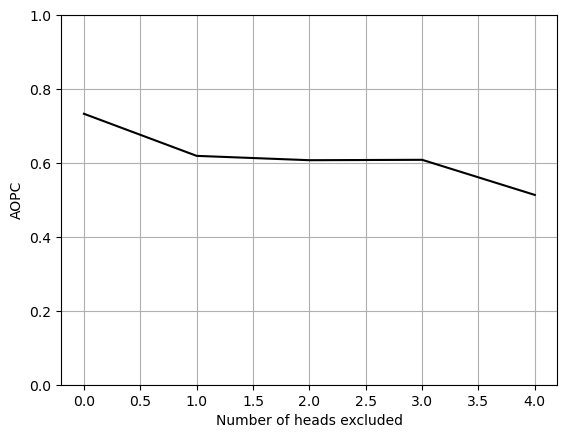

In [69]:
with open(f'test_outputs/exp22/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp22/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(5), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()

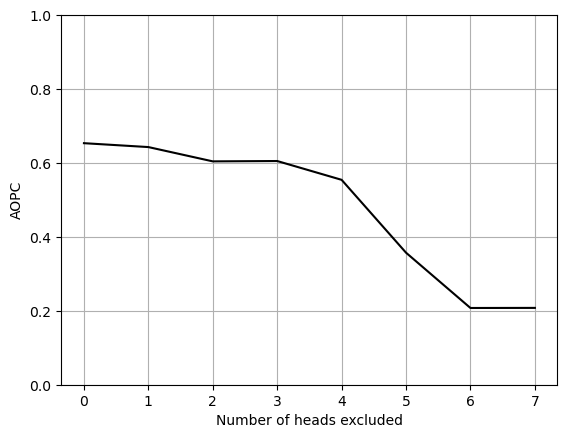

In [70]:
with open(f'test_outputs/exp25/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp25/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(8), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()


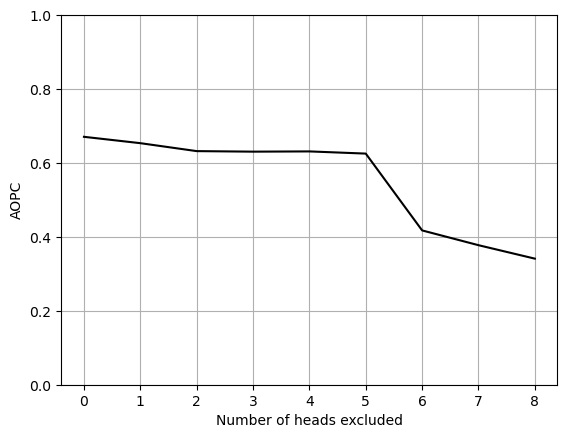

In [72]:
with open(f'test_outputs/exp29/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp29/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(9), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()

## Diversity

In [77]:
experiment_ids = [21, "26-2", 28, 30, 27, 42]
d_min = [2,5,7,9,10,11]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


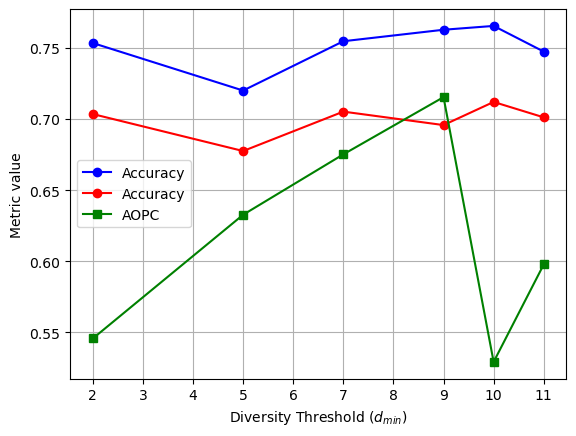

In [78]:
# Plotting
plt.plot(d_min, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(d_min, f1_scores, marker='o', color='red', label='Accuracy')
plt.plot(d_min, aopc_scores, marker='s', color='green', label='AOPC')

# Axis labels
plt.xlabel('Diversity Threshold ($d_{min}$)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(range(2,12))

plt.grid(True)

# Legend
plt.legend()

# Show plot
plt.show()

## Main Results

In [211]:
class_names = CLASS_DICT.values()

# Load the experiments
#experiment_ids = [16,18,19]
experiment_ids = [37,38,39,40]
split_results = []
classwise_accuracies = []

for split_id in range(0,10):

    with open(f'test_outputs/motor_imagery/split{split_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/motor_imagery/split{split_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/motor_imagery/split{split_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/motor_imagery/split{split_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    # Calculate AOPC
    aopc = (AOPC / total).mean().numpy()

    row = {
        "split": split_id,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "aopc": aopc
    }
    split_results.append(row)

    # Create a confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    class_accuracy = confusion.diagonal()/confusion.sum(axis=1)

    classwise_row = { class_name: class_accuracy[i] for i, class_name in enumerate(class_names) }
    classwise_row["split"] = split_id
    classwise_accuracies.append(classwise_row)

c:\Users\s222165064\.conda\envs\EEG-SESM\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\s222165064\.conda\envs\EEG-SESM\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [212]:
results_df = pd.DataFrame(split_results)
classwise_results = pd.DataFrame(classwise_accuracies)

display(results_df)
display(classwise_results)

,split,accuracy,precision,recall,aopc
0,0,0.531000,0.531210,0.531000,0.63852465
1,1,0.535000,0.556179,0.535000,0.54282415
2,2,0.547000,0.549256,0.547000,0.6012049
3,3,0.555000,0.577878,0.555000,0.5545018
4,4,0.532000,0.544112,0.532000,0.56454223
5,5,0.534615,0.554883,0.534615,0.5496932
6,6,0.625000,0.658181,0.625000,0.5779064
7,7,0.500000,0.250000,0.500000,0.45926824
8,8,0.546000,0.612147,0.546000,0.52856123
9,9,0.500000,0.250000,0.500000,0.76329774


,Left,Right,split
0,0.490000,0.572000,0
1,0.842000,0.228000,1
2,0.654000,0.440000,2
3,0.826000,0.284000,3
4,0.794000,0.270000,4
5,0.838462,0.230769,5
6,0.854000,0.396000,6
7,1.000000,0.000000,7
8,0.930000,0.162000,8
9,1.000000,0.000000,9


In [30]:
(0.762400+0.264516+0.864767+0.940127+0.643777)/5

0.6951174

In [213]:
# Calculate mean and standard deviation
agg_mean = results_df.loc[:,["accuracy","precision", "recall","aopc"]].mean()
agg_std = results_df.loc[:,["accuracy","precision", "recall","aopc"]].std()

# Create a new dataframe for aggregation
agg_df = pd.DataFrame({'mean': agg_mean, 'std': agg_std})
display(agg_df)

,mean,std
accuracy,0.540562,0.03485
precision,0.508385,0.141215
recall,0.540562,0.03485
aopc,0.578032,0.080174


In [8]:
# Calculate mean and standard deviation
classwise_agg_mean = classwise_results.loc[[0,1,2],list(class_names)].mean()
classwise_agg_std = classwise_results.loc[[0,1,2],list(class_names)].std()

# Create a new dataframe for classwise_aggregation
classwise_agg_df = pd.DataFrame({'mean': classwise_agg_mean, 'std': classwise_agg_std})
display(classwise_agg_df)

,mean,std
W,0.738366,0.091916
N1,0.286102,0.018774
N2,0.850888,0.026779
N3,0.862922,0.111993
REM,0.724414,0.091324


In [143]:
y_trues = []
y_preds = []

for split_id in range(0,10):

    with open(f'test_outputs/motor_imagery/split{split_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/motor_imagery/split{split_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)
    
    y_trues.append(y_true)
    y_preds.append(y_pred)

y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)

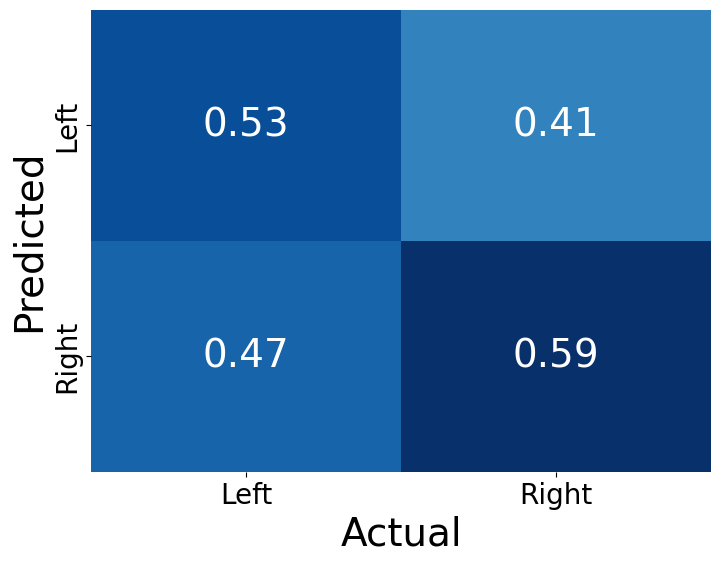

In [144]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    C,
    vmin=0,
    annot=True,
    annot_kws={"fontsize":28},
    cmap='Blues',
    cbar=False
)
ax.set_xticklabels(CLASS_DICT.values(), fontsize=20)
ax.set_yticklabels(CLASS_DICT.values(), fontsize=20)
ax.set_xlabel("Actual", fontsize=28)
ax.set_ylabel("Predicted", fontsize=28)
plt.show()